In [1]:
from getpass import getpass
openaikey = getpass('##')

Get Key from SegMind

In [2]:
segmindkey = getpass('##')

In [3]:
chatgpt_url = "https://api.openai.com/v1/chat/completions"
chatgpt_headers = {
    "content-type": "application/json",
    "Authorization":"Bearer {}".format(openaikey)}

In [4]:
import requests
import json
from pprint import pprint

def fetch_illustrator_prompts(prompt, url, headers, max_retries=3):
    retries = 0

    while retries < max_retries:
        # Define the payload for the chat model
        messages = [
            {"role": "system", "content": "You are an expert author who can read children's stories and create moral stories for an illustrator, and create short children stories of length < 500 words."},
            {"role": "user", "content": prompt}
        ]

        chatgpt_payload = {
            "model": "gpt-3.5-turbo-16k",
            "messages": messages,
            "temperature": 1.3,
            "max_tokens": 2000,
            "top_p": 1,
            "stop": ["###"]
        }

        # Make the request to OpenAI's API
        response = requests.post(url, json=chatgpt_payload, headers=headers)
        response_json = response.json()

        try:
            # Extract AIML from the API's response
            output = json.loads(response_json['choices'][0]['message']['content'].strip())
            # pprint(output)
            return output
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            retries += 1
            print(f"Retry attempt {retries} out of {max_retries}")

    # If max retries are reached without a successful response, return None or handle it as needed.
    return None


In [5]:
import json

def generate_prompt(text, count):
    prompt_prefix = """{}
------------------------------------
Generate {} short briefs as a list from the above story to give as input to an illustrator to generate relevant children's story illustrations.
Strictly generate each brief as a single sentence that contains all the necessary information.
Strictly output your response in a JSON list format, adhering to the following sample structure:""".format(json.dumps(text), json.dumps(count))

    sample_output = {"illustrations": ["...", "...", "...","...","..."]}

    prompt_postinstruction = "\nOutput:"

    return prompt_prefix + json.dumps(sample_output) + prompt_postinstruction



In [6]:
import requests
import json
from pprint import pprint

def fetch_story_prompts(prompt, url, headers):
    retries = 0

    # Define the payload for the chat model
    messages = [
        {"role": "system", "content": "You are an expert author who can create children short stories."},
        {"role": "user", "content": prompt}
    ]

    chatgpt_payload = {
        "model": "gpt-3.5-turbo-16k",
        "messages": messages,
        "temperature": 1.1,
        "max_tokens": 2000,
        "top_p": 1,
        "stop": ["###"]
    }

        # Make the request to OpenAI's API
    response = requests.post(url, json=chatgpt_payload, headers=headers)
    response_json = response.json()

    return response_json



In [7]:
# Generate a short story
story_prompt = "The creative story should have a title first, should be a children story with moral values. Use simple vocabulary. The narration should strictly contain animals. Strictly refer to the characters with the animal types. Dont give any name to the animals. All the characters should be different animal types. Indulge curiosity in the story. It should contain less than 300 words"
story_json = fetch_story_prompts(story_prompt,chatgpt_url,chatgpt_headers)

In [8]:
print(story_json)
story = story_json['choices'][0]['message']['content']
print(story)

{'id': 'chatcmpl-AmbfPVJz1Ma0dV9Hhnmwopbpx0Exf', 'object': 'chat.completion', 'created': 1736147899, 'model': 'gpt-3.5-turbo-16k-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Title: The Little Lost Explorer\n\nOnce upon a time in the vibrant jungle, there lived a curious little elephant, a brave little lion, and a clever little monkey. One sunny day, they decided to embark on an exciting adventure to explore the unknown.\n\nAs they ventured deeper into the jungle, their excitement grew. They encountered colorful butterflies, playful monkeys swinging from tree to tree, and melodic birds singing their sweet songs. The friends marveled at nature\'s wonders.\n\nSuddenly, they stumbled upon a peculiar trail leading to a dense forest. Intrigued by what lay beyond, the little lion eagerly suggested, "Let\'s follow the path, and see where it leads us!" The little elephant, with his trunk held high, agreed, swinging his long ears in excitement. The monkey, known f

In [9]:
# https://momlovesbest.com/short-moral-stories-kids

image_count = 3
prompt = generate_prompt(story, image_count)

print (prompt)

"Title: The Little Lost Explorer\n\nOnce upon a time in the vibrant jungle, there lived a curious little elephant, a brave little lion, and a clever little monkey. One sunny day, they decided to embark on an exciting adventure to explore the unknown.\n\nAs they ventured deeper into the jungle, their excitement grew. They encountered colorful butterflies, playful monkeys swinging from tree to tree, and melodic birds singing their sweet songs. The friends marveled at nature's wonders.\n\nSuddenly, they stumbled upon a peculiar trail leading to a dense forest. Intrigued by what lay beyond, the little lion eagerly suggested, \"Let's follow the path, and see where it leads us!\" The little elephant, with his trunk held high, agreed, swinging his long ears in excitement. The monkey, known for his cleverness, joined them with a sparkle in his eye.\n\nThey followed the trail, wading through tall grass and swaying vines, their hearts pounding with anticipation. As they journeyed further, they d

In [10]:
illustrator_prompts = fetch_illustrator_prompts(prompt,chatgpt_url,chatgpt_headers)
print (illustrator_prompts)
for each in illustrator_prompts['illustrations']:
  print (each)

{'illustrations': ['The curious little elephant, brave little lion, and clever little monkey venture into the vibrant jungle, encountering colorful butterflies, playful monkeys swinging from tree to tree, and melodic birds singing their sweet songs.', 'The little lion, elephant, and monkey follow a peculiar trail through tall grass and swaying vines, leading them to a hidden waterfall with a tranquil pond.', 'The animals come across a trapped fluffy rabbit behind the waterfall, and with their help, they rescue the bunny and find a secret path back to their animal friends, meeting new friends along the way.']}
The curious little elephant, brave little lion, and clever little monkey venture into the vibrant jungle, encountering colorful butterflies, playful monkeys swinging from tree to tree, and melodic birds singing their sweet songs.
The little lion, elephant, and monkey follow a peculiar trail through tall grass and swaying vines, leading them to a hidden waterfall with a tranquil po

In [11]:
from segmind import SDXL
model = SDXL(segmindkey)

In [12]:
import os
import io
import requests
from PIL import Image
import random

def generate_images(prompts, style):
    all_images =[]

    num_images = len(prompts)

    currentseed = random.randint(1, 1000000)
    print ("seed ",currentseed)

    negative_prompt = "photorealistic, realistic, photograph, deformed, mutated, stock photo, 35mm film, deformed, glitch, low contrast, noisy"

    for i, prompt in enumerate(prompts):

        final_prompt = "{},{}".format(prompt.replace('.',","),style)
        img = model.generate(prompt = final_prompt,negative_prompt=negative_prompt,samples = 1,style = style,scheduler="UniPC",
                             seed =currentseed, num_inference_steps=30)


        print (f"Image {i + 1}/{num_images} is generated")
        # img will be a PIL image
        all_images.append(img)

    return all_images

In [18]:
# style = "watercolor"
style = "kawaii"
all_images = generate_images(illustrator_prompts['illustrations'],style)

seed  322901
Success! You have 0.0 credits remaining
Image 1/3 is generated
Success! You have 0.0 credits remaining
Image 2/3 is generated
Success! You have 0.0 credits remaining
Image 3/3 is generated


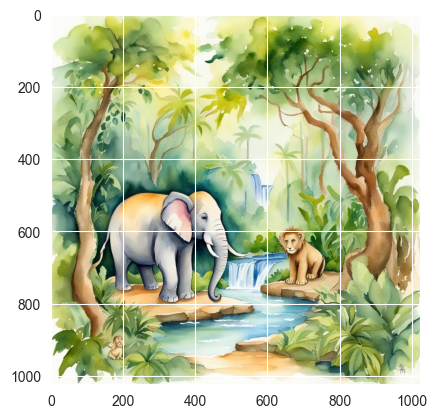

In [19]:
import matplotlib.pyplot as plt
plt.imshow(all_images[0])
plt.imshow(all_images[1])

In [20]:
# Generate story summary

In [21]:
# Extract Title and sentences
story_lines = story.split('\n')
title = story_lines[0]
#for line in story_lines:
    #print(line)
line_count = len(story_lines)
lines_per_image = line_count//image_count
lines_per_image
#story_lines[7]

7

In [23]:
import gradio as gr
import shutil
import os


#def create_illustrations():
    #story_prompt = "The creative story should have a title first, should be a children story with moral values. The narration should strictly contain animals. Strictly refer to the characters with the animal types. Dont give any name to the animals. All the characters should be different animal types. Indulge curiosity in the story. It should contain less than 300 words"
    #story_json = fetch_story_prompts(story_prompt,chatgpt_url,chatgpt_headers)
    #story = story_json['choices'][0]['message']['content']
    #illustrator_prompts = fetch_illustrator_prompts(prompt, chatgpt_url, chatgpt_headers)
    #pil_images = generate_images(illustrator_prompts['illustrations'], story)

    #return pil_images

#topics = ["watercolor", "comic book", "kawaii", "line art"]

with gr.Blocks() as demo:
    gr.Markdown("# Kid's story illustrations generator")
    gr.Markdown("## "+title)
    sc=1
    for ii in (0,image_count-1):

        for lc in range(lines_per_image):
            clean_story_line = story_lines[sc].strip().strip('')
            gr.Markdown(clean_story_line)
            sc=sc+1
        gallery = gr.Image(value=all_images[ii])

    for lc in (sc,line_count-1):
            gr.Markdown(story_lines[lc])



# demo.launch(debug=True, enable_queue=True)
demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
